# PyMC

In an effort to compare and contrast vs numpyro, going to test out pymc and hopefully write up something longer to show the syntax differences and similarities, and recommend one for a beginner.

In [21]:
# Preamble
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# next, pymc specific setup
import pymc as pm

We'll follow the same simulated data as in the [GLM:Linear Regression pymc docs](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)

In [22]:
# Simulate Data
np.random.seed(42)

size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(0, 0.5, size)

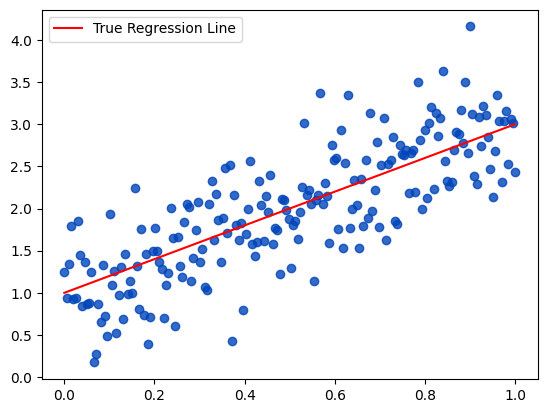

In [23]:
plt.scatter(x, y, alpha=0.8)
plt.plot(x, true_regression_line, c='r', label='True Regression Line')
plt.legend();

Model Estimation Syntax with pymc, takes about 5-9 sec.

In [24]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    mu = intercept + slope * x
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

The base `pymc` sampler takes like 6 sec on my local machine:

In [25]:
with model:
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(1000, nuts_sampler='pymc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


We can get some speedups by using a different sampler right off the bat. For instance, we can use the `numpyro` sampler (as long as the model is continous). On my machine, this results in a 3x speedup and completes in ~2 sec.

In [32]:
with model:
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(1000, nuts_sampler='numpyro')

Compiling...
/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-FRV7Ufu--py3.10/lib/python3.10/site-packages/pymc/sampling/jax.py:678: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:00.420041
Sampling...
sample: 100%|██████████| 2000/2000 [00:00<00:00, 8055.78it/s, 3 steps of size 3.95e-01. acc. prob=0.93] 
Sampling time = 0:00:03.051738
Transforming variables...
Transformation time = 0:00:00.049992


## Arviz

`Arviz` is the premier library for understanding and analyzing PPL inference results and supports multiple languages. Regardless of which PPL you choose, you'll likely be able to analyze the results using `Arviz`. 

First thing we want to show is to inspect a summary table of our regression coefficient estimates, using the `az.summary()` function:

In [26]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.923,0.066,0.801,1.047,0.002,0.001,1867.0,2050.0,1.0
slope,2.113,0.113,1.913,2.338,0.003,0.002,1927.0,2038.0,1.0
sigma,0.469,0.023,0.427,0.513,0.000,0.000,2349.0,2412.0,1.0


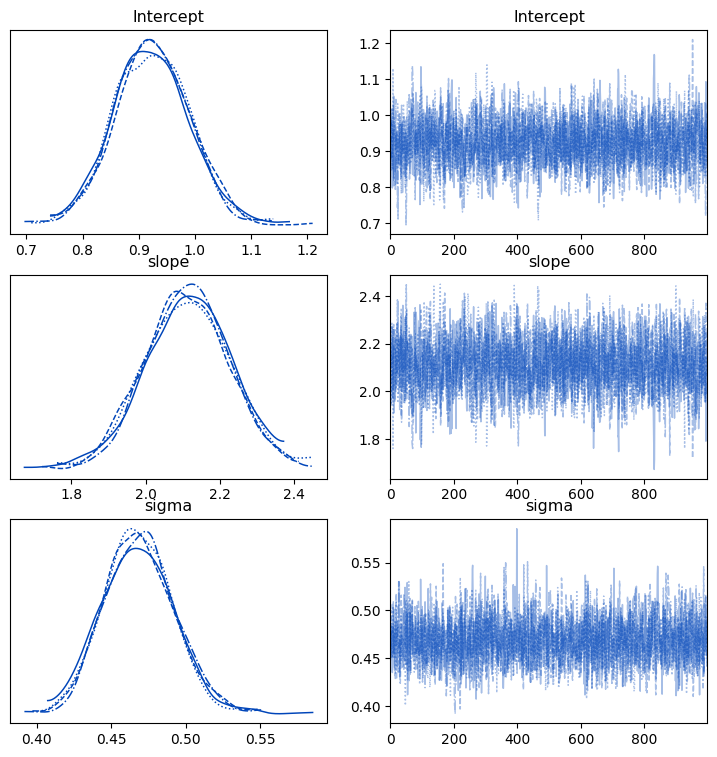

In [27]:
az.plot_trace(idata, var_names=['Intercept', 'slope', 'sigma'], figsize=(9,9));

The result is an `arviz.InferenceData` object that's essentially an `xarray.Dataset`

In [28]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## Fitted line

In [29]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["slope"] * xr.DataArray(x)

array([[<Axes: xlabel='y_dim_0', ylabel='y'>]], dtype=object)

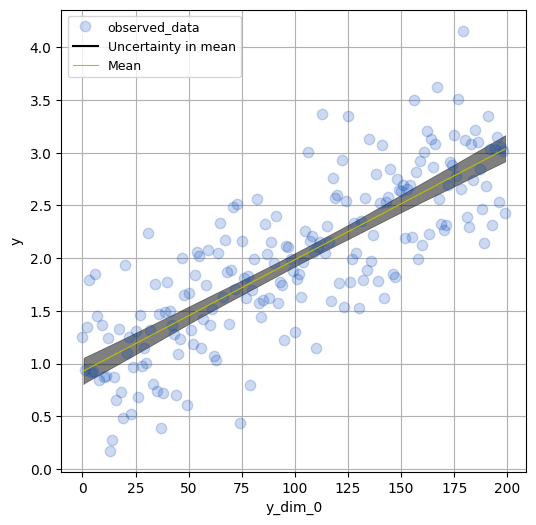

In [31]:
az.style.use('arviz-bluish')
az.plot_lm(y='y', idata=idata, y_model='y_model', kind_pp='hdi', kind_model='hdi', figsize=(6,6), textsize=9)

In [16]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.925,0.066,0.812,1.058,0.002,0.001,1417.0,1678.0,1.0
slope,2.109,0.115,1.888,2.329,0.003,0.002,1406.0,1627.0,1.0
sigma,0.468,0.024,0.424,0.514,0.001,0.000,2098.0,2128.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

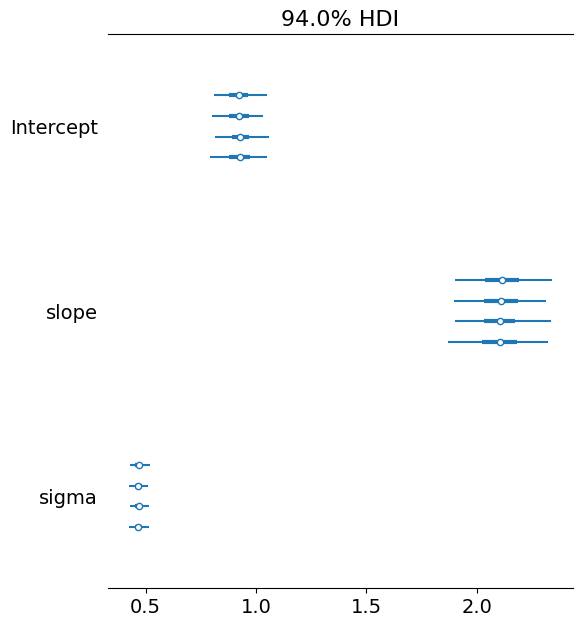

In [17]:
az.plot_forest(idata)